In [1]:
from transformers import AutoTokenizer
from scapy.all import *
import torch
import sqlparse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
import joblib
from sklearn.base import BaseEstimator,TransformerMixin
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
import random
import matplotlib.pyplot as plt
from nfstream import NFStreamer
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)


cpu


/usr/local/lib/python3.10/dist-packages/torch/xpu/__init__.py:57: UserWarning: XPU device count is zero! (Triggered internally at /build/pytorch/c10/xpu/XPUFunctions.cpp:50.)
  return torch._C._xpu_getDeviceCount()


In [3]:
path = os.path.abspath("") + '/../datasets/classification/' 
redis_warning_request = path + 'warning_redis_request.pcapng'
redis_warning_response = path + 'warning_redis_response.pcapng'
mysql_warning = path + 'mysql_warning.pcapng'
secure_http = path + 'plain_pass.pcap'
benign_path = path + 'benign/part'
redis_path = path + 'redis/part'

sql_injection = path + 'sql-injection'
xss = path + 'xss.pcapng'
ddos = path + 'ddos'

## Gather payloads
Extract payloads from gathered pcap files

In [4]:
labels = {
    'BENIGN': 1,
    'SQL': 2,
    'REDIS': 3,
    'PLAIN_DATA': 4
}
def get_payloads(filename):
    reader = rdpcap(filename)
    packets = []
    for packet in reader:
        if Raw in packet: 
            payload = bytes(packet[Raw].load)
            packets.append(payload) 
    return packets
sql_packets = get_payloads(mysql_warning)
redis_packets = get_payloads(redis_path)
http_packets = get_payloads(secure_http)
benign_packets = get_payloads(benign_path)
all_packets_plain = benign_packets + sql_packets + redis_packets + http_packets 

## Preprocess
Remove quotes, integers, newline characters, for redis queries - split them into parts
Remove words longer than 15 chars, replace character sequences with 1 char
For stemmer I've chosen LancasterStemmer as we don't need high linguistic accuracy

In [5]:
import re
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

## Place to play with sql sanitize rules
def clear_sql(packet):
    query = ''
    parsed = sqlparse.parse(packet)
    if len(parsed) == 0:
        return packet
    for token in parsed[0].tokens:
        query += ''.join(i for i in token.value if not i.isdigit())
    return query.replace('  ', ' ') + ';'
def sanitize(payload):
    try:
        text = payload.decode('utf-8', errors='replace')
        text = text.lower()
        text = re.sub(r'[\x00-\x1F\x7F]', '', text)
        text = re.sub(r'\$\d+', ' ', text)
        text = re.sub(r'\{.*?\}', ' ', text)
        text = re.sub('".*?"', '', text)
        
        text = re.sub('\'.*?\'', '', text)
        text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("_", " ").replace('-', '').replace('/', '').replace('gymbeam', '').replace('%20', ' ').replace('%2A', '*').replace('%3D', '=').replace('%3B', ';')
        text = ''.join(t for t in text if not t.isdigit())
        new_text = ''
        for t in text.split(' '):
            if len(t) < 15:
                t = re.sub(r'(\w)\1+', r'\1', t)
                t = stemmer.stem(t)
                new_text += t + ' '
        
        return new_text
    except Exception as e:
        return ''
def preprocess(packets):
    result = []
    

class PacketSanitizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        result = []
        for packet in X:
            result.append(clear_sql(sanitize(packet)))
        return result

## Preprocess dataset

In [6]:
y = []
y.extend(labels['BENIGN'] for _ in range(len(benign_packets)))
y.extend(labels['SQL'] for _ in range(len(sql_packets)))
y.extend(labels['REDIS'] for _ in range(len(redis_packets)))
y.extend(labels['PLAIN_DATA'] for _ in range(len(http_packets)))
y = pd.DataFrame(y)

print(f'Benign: {len(benign_packets)}')
print(f'SQL: {len(sql_packets)}')
print(f'HTTP: {len(http_packets)}')
print(f'Redis: {len(redis_packets)}')
print(f'y: {len(y)}')

Benign: 46567
SQL: 19272
HTTP: 5795
Redis: 12174
y: 83808


## Separate packets into train, test and val datasets

Length of data: 83808, length of y: 83808
Train size: 58665
Test size: 22628
Val size: 2515


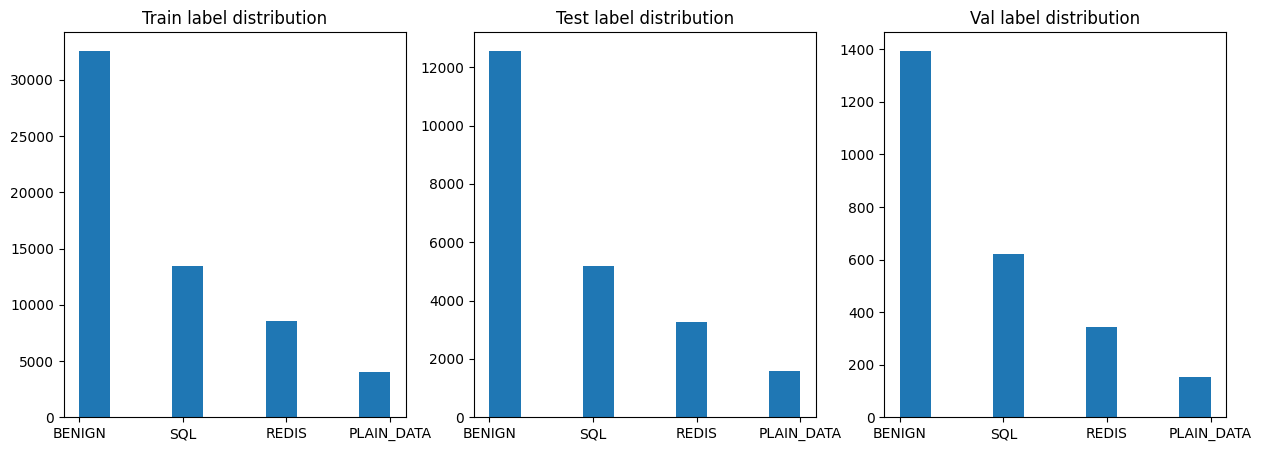

In [7]:
train_size = 0.7
test_size = 0.9
def split_data(data, coef = 0.8):
    ix = int(len(data)*coef)
    return data[:ix], data[ix:]
combined = list(zip(all_packets_plain, y[0]))
random.shuffle(combined)
df, y_shuffled = zip(*combined)
print(f'Length of data: {len(df)}, length of y: {len(y_shuffled)}')
train_X, test_X = split_data(df, train_size)
train_y, test_y = split_data(y_shuffled, train_size)
test_X, val_X = split_data(test_X, test_size)
test_y, val_y = split_data(test_y, test_size)
print(f'Train size: {len(train_X)}')
print(f'Test size: {len(test_X)}')
print(f'Val size: {len(val_X)}')

figure, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].hist(train_y)
axes[0].set_title('Train label distribution')
axes[0].set_xticks(list(labels.values()), labels = labels.keys())
axes[1].hist(test_y)
axes[1].set_title('Test label distribution')
axes[1].set_xticks(list(labels.values()), labels = labels.keys())
axes[2].hist(val_y)
axes[2].set_title('Val label distribution')
axes[2].set_xticks(list(labels.values()), labels = labels.keys())
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
pipeline = make_pipeline(PacketSanitizer(),
                         TfidfVectorizer(token_pattern = r'([a-zA-Z0-9-/]{3,10})', 
                             min_df=10, 
                             stop_words= ['amasty', 'applepay', 'magento']),
                         StandardScaler(with_mean=False),
                         KNeighborsClassifier(n_neighbors = 5, n_jobs = 2))

pipeline.fit(train_X, train_y)

Pipeline(steps=[('packetsanitizer', PacketSanitizer()),
                ('tfidfvectorizer',
                 TfidfVectorizer(min_df=10,
                                 stop_words=['amasty', 'applepay', 'magento'],
                                 token_pattern='([a-zA-Z0-9-/]{3,10})')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=2))])

In [10]:
pred_y = pipeline.predict(test_X)
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           1       0.89      1.00      0.94     12570
           2       0.99      0.99      0.99      5186
           3       0.98      0.51      0.67      3282
           4       1.00      1.00      1.00      1590

    accuracy                           0.93     22628
   macro avg       0.97      0.87      0.90     22628
weighted avg       0.93      0.93      0.92     22628



## Evaluation

In [11]:
from sklearn.metrics import confusion_matrix
def calculate_metrics(matrix):
    tp = matrix[0][0]
    fn = matrix[0][1]
    fp = matrix[1][0]
    tn = matrix[1][1]
    pre = tp / (fp + tp)
    rec = tp/(tp + fn)
    f1 = 2*((rec*pre)/(pre + rec))
    return pre, rec, f1 #precision, recall, f1
matrixes = multilabel_confusion_matrix(test_y, pred_y)
metrics = []
for matrix in matrixes:
    metrics.append(calculate_metrics(matrix))
for key, value in labels.items():
    print(f'{key} precision: {metrics[value][0]}')
    print(f'{key} recall: {metrics[value][1]}')
    print(f'{key} f1: {metrics[value][2]}\n')
    

BENIGN precision: 0.9965659340659341
BENIGN recall: 0.99828001375989
BENIGN f1: 0.9974222374978519

SQL precision: 0.9235513482501434
SQL recall: 0.9985009821151659
SQL f1: 0.959564850230987

REDIS precision: 0.9997623461191121
REDIS recall: 0.9998098678581614
REDIS f1: 0.9997861064239371



IndexError: list index out of range

## Save models

In [38]:
joblib.dump(pipeline, 'models/vuln_pipeline.gz')

['models/vuln_pipeline.gz']

In [20]:
pipeline = joblib.load('models/vuln_pipeline.gz')